In [1]:
# Parcellation x

In [2]:
%matplotlib inline
import os 
import nibabel as nb 
import numpy as np 
import pandas as pd##
pd.options.display.max_rows=200


parcellation_dir = '/scr/malta1/Github/ENIGMA_TOURETTE/parcellation/'
ahba_dir         = '/scr/malta1/Github/ENIGMA_TOURETTE/AHBA/ahba_data'

# Get fsaverage data


In [3]:
def return_fsaverage_data(freesurfer_dir, fsaverage_id):
    datadir = os.path.join(freesurfer_dir, fsaverage_id, 'surf')
    
    # fsaverage
    fsaverage = dict()
    fsaverage['infl_left']  = os.path.join(datadir, 'lh.inflated')
    fsaverage['infl_right'] = os.path.join(datadir, 'rh.inflated')
    fsaverage['pial_left']  = os.path.join(datadir, 'lh.pial')
    fsaverage['pial_right'] = os.path.join(datadir, 'rh.pial')
    fsaverage['sulc_left']  = os.path.join(datadir, 'lh.sulc')
    fsaverage['sulc_right'] = os.path.join(datadir, 'rh.sulc')
    
    return fsaverage

# Get parcellation annotation data
- parcellation 1: Desikan-Killany – 72 ROIs (Desikan,Neuroimage, 2006)  
    - https://surfer.nmr.mgh.harvard.edu/ftp/articles/desikan06-parcellation.pdf
- parcellation 2: Desikan-Killany sub-parcellation – 308 Cortical ROIs (Whitaker,PNAS, 2016) 
    - http://www.pnas.org/content/113/32/9105.full
- parcellation 3: Glasser Parcellation – 362 Cortical ROIs (Glasser, Nature, 2016) 
    - http://www.nature.com/nature/journal/v536/n7615/full/nature18933.html?foxtrotcallback=true

##### see here for more details 
- https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation
- https://github.com/KirstieJane/NSPN_WhitakerVertes_PNAS2016/tree/master/FS_SUBJECTS/fsaverageSubP/parcellation

In [4]:
def return_fsaverage_parcellation(freesurfer_dir, fsaverage_id, parcelation):
    parc = os.path.join(parcellation_dir, fsaverage_id, 'label', parcelation)
    parc_labels, parc_ctab, parc_names = nb.freesurfer.read_annot(parc)
    return parc_labels, parc_ctab, parc_names

fsaverage = return_fsaverage_data(parcellation_dir, 'fsaverage')
fsaverage5 = return_fsaverage_data(parcellation_dir, 'fsaverage5')


DK_lh_labels, DK_lh_ctab, DK_lh_names = return_fsaverage_parcellation(parcellation_dir, 'fsaverage', 'lh.aparc.annot')
DK_rh_labels, DK_rh_ctab, DK_rh_names = return_fsaverage_parcellation(parcellation_dir, 'fsaverage', 'rh.aparc.annot')

DK500_lh_labels, DK500_lh_ctab, DK500_lh_names = return_fsaverage_parcellation(parcellation_dir, 'fsaverage', 'lh.500.aparc.annot')
DK500_rh_labels, DK500_rh_ctab, DK500_rh_names = return_fsaverage_parcellation(parcellation_dir, 'fsaverage', 'rh.500.aparc.annot')

HCP_lh_labels, HCP_lh_ctab, HCP_lh_names = return_fsaverage_parcellation(parcellation_dir, 'fsaverage', 'lh.HCP-MMP1.annot')
HCP_rh_labels, HCP_rh_ctab, HCP_rh_names = return_fsaverage_parcellation(parcellation_dir, 'fsaverage', 'rh.HCP-MMP1.annot')

# plot parcellation 

In [5]:
def plot_surf(fsaverage, surf_map_l, surf_map_r,
              threshold=None,  alpha=0.7, cmap='hot', vmin = None, vmax = None,
              bg_on_data = 1, output_file=None,
                  ):
    
    # Import libraries
    import nibabel
    import numpy as np
    import matplotlib.pyplot as plt

    from mpl_toolkits.mplot3d import Axes3D
    from nibabel import gifti

    from nilearn._utils.compat import _basestring
    from nilearn.plotting.img_plotting import _get_colorbar_and_data_ranges
    from nilearn.plotting.surf_plotting import load_surf_data, load_surf_mesh


    # load mesh and derive axes limits
    mesh_left = load_surf_mesh(fsaverage['pial_left'])
    mesh_right = load_surf_mesh(fsaverage['pial_right'])

    coords_left, faces_left = mesh_left[0], mesh_left[1]
    coords_right, faces_right = mesh_right[0], mesh_right[1]

    limits = [-65, 33]

    avg_method = 'mean'
    darkness = 1

    # if no cmap is given, set to matplotlib default
    if cmap is None:
        cmap = plt.cm.get_cmap(plt.rcParamsDefault['image.cmap'])
    else:
        # if cmap is given as string, translate to matplotlib cmap
        if isinstance(cmap, _basestring):
            cmap = plt.cm.get_cmap(cmap)

    def subplot(surf_map, bg_map, subplot_id, coords, faces, elev, azim, vmin=vmin, vmax=vmax, bg_on_data= bg_on_data):

        ax = fig.add_subplot(subplot_id, projection='3d', xlim=limits, ylim=limits)
        ax.view_init(elev=elev, azim=azim)
        ax.set_axis_off()
        p3dcollec = ax.plot_trisurf(coords[:, 0], coords[:, 1], coords[:, 2], triangles=faces, linewidth=0.,
                                    antialiased=False, color='red')

        # If depth_map and/or surf_map are provided, map these onto the surface
        # set_facecolors function of Poly3DCollection is used as passing the
        # facecolors argument to plot_trisurf does not seem to work
        if bg_map is not None or surf_map is not None:

            face_colors = np.ones((faces.shape[0], 4))
            # face_colors[:, :3] = .5*face_colors[:, :3]  # why this?

            if bg_map is not None:
                bg_data = load_surf_data(bg_map)
                if bg_data.shape[0] != coords.shape[0]:
                    raise ValueError('The bg_map does not have the same number '
                                     'of vertices as the mesh.')
                bg_faces = np.mean(bg_data[faces], axis=1)
                bg_faces = bg_faces - bg_faces.min()
                bg_faces = bg_faces / bg_faces.max()
                # control background darkness
                bg_faces *= darkness
                face_colors = plt.cm.gray_r(bg_faces)

            # modify alpha values of background
            face_colors[:, 3] = alpha * face_colors[:, 3]
            # should it be possible to modify alpha of surf data as well?

            if surf_map is not None:
                surf_map_data = surf_map  # load_surf_data(surf_map)
                if len(surf_map_data.shape) is not 1:
                    raise ValueError('surf_map can only have one dimension but has'
                                     '%i dimensions' % len(surf_map_data.shape))
                if surf_map_data.shape[0] != coords.shape[0]:
                    raise ValueError('The surf_map does not have the same number '
                                     'of vertices as the mesh.')

                # create face values from vertex values by selected avg methods
                if avg_method == 'mean':
                    surf_map_faces = np.mean(surf_map_data[faces], axis=1)
                elif avg_method == 'median':
                    surf_map_faces = np.median(surf_map_data[faces], axis=1)

                # if no vmin/vmax are passed figure them out from data
                if vmin is None:
                    vmin = np.nanmin(surf_map_faces)
                if vmax is None:
                    vmax = np.nanmax(surf_map_faces)

                # treshold if inidcated
                if threshold is None:
                    kept_indices = np.where(surf_map_faces)[0]
                else:
                    kept_indices = np.where(np.abs(surf_map_faces) >= threshold)[0]

                surf_map_faces = surf_map_faces - vmin
                surf_map_faces = surf_map_faces / (vmax - vmin)

                # multiply data with background if indicated
                if bg_on_data:
                    face_colors[kept_indices] = cmap(surf_map_faces[kept_indices]) \
                                                * face_colors[kept_indices]
                else:
                    face_colors[kept_indices] = cmap(surf_map_faces[kept_indices])

            p3dcollec.set_facecolors(face_colors)

    fig = plt.figure(figsize=(60, 20))

    subplot(surf_map_l, fsaverage['sulc_left'], 141, coords_left, faces_left, elev=0, azim=180, bg_on_data= bg_on_data)
    subplot(surf_map_l, fsaverage['sulc_left'], 142, coords_left, faces_left, elev=0, azim=0, bg_on_data= bg_on_data)
    subplot(surf_map_r, fsaverage['sulc_right'], 143, coords_right, faces_right, elev=0, azim=180, bg_on_data= bg_on_data)
    subplot(surf_map_r, fsaverage['sulc_right'], 144, coords_right, faces_right, elev=0, azim=0, bg_on_data= bg_on_data)

    plt.tight_layout()
    
    # save figure if output file is given
    if output_file is not None:
        fig.savefig(output_file)
        plt.close(fig)

# Desikan-Killany 72 ROIS (cortical and subcortical)

Number of parcels = 72


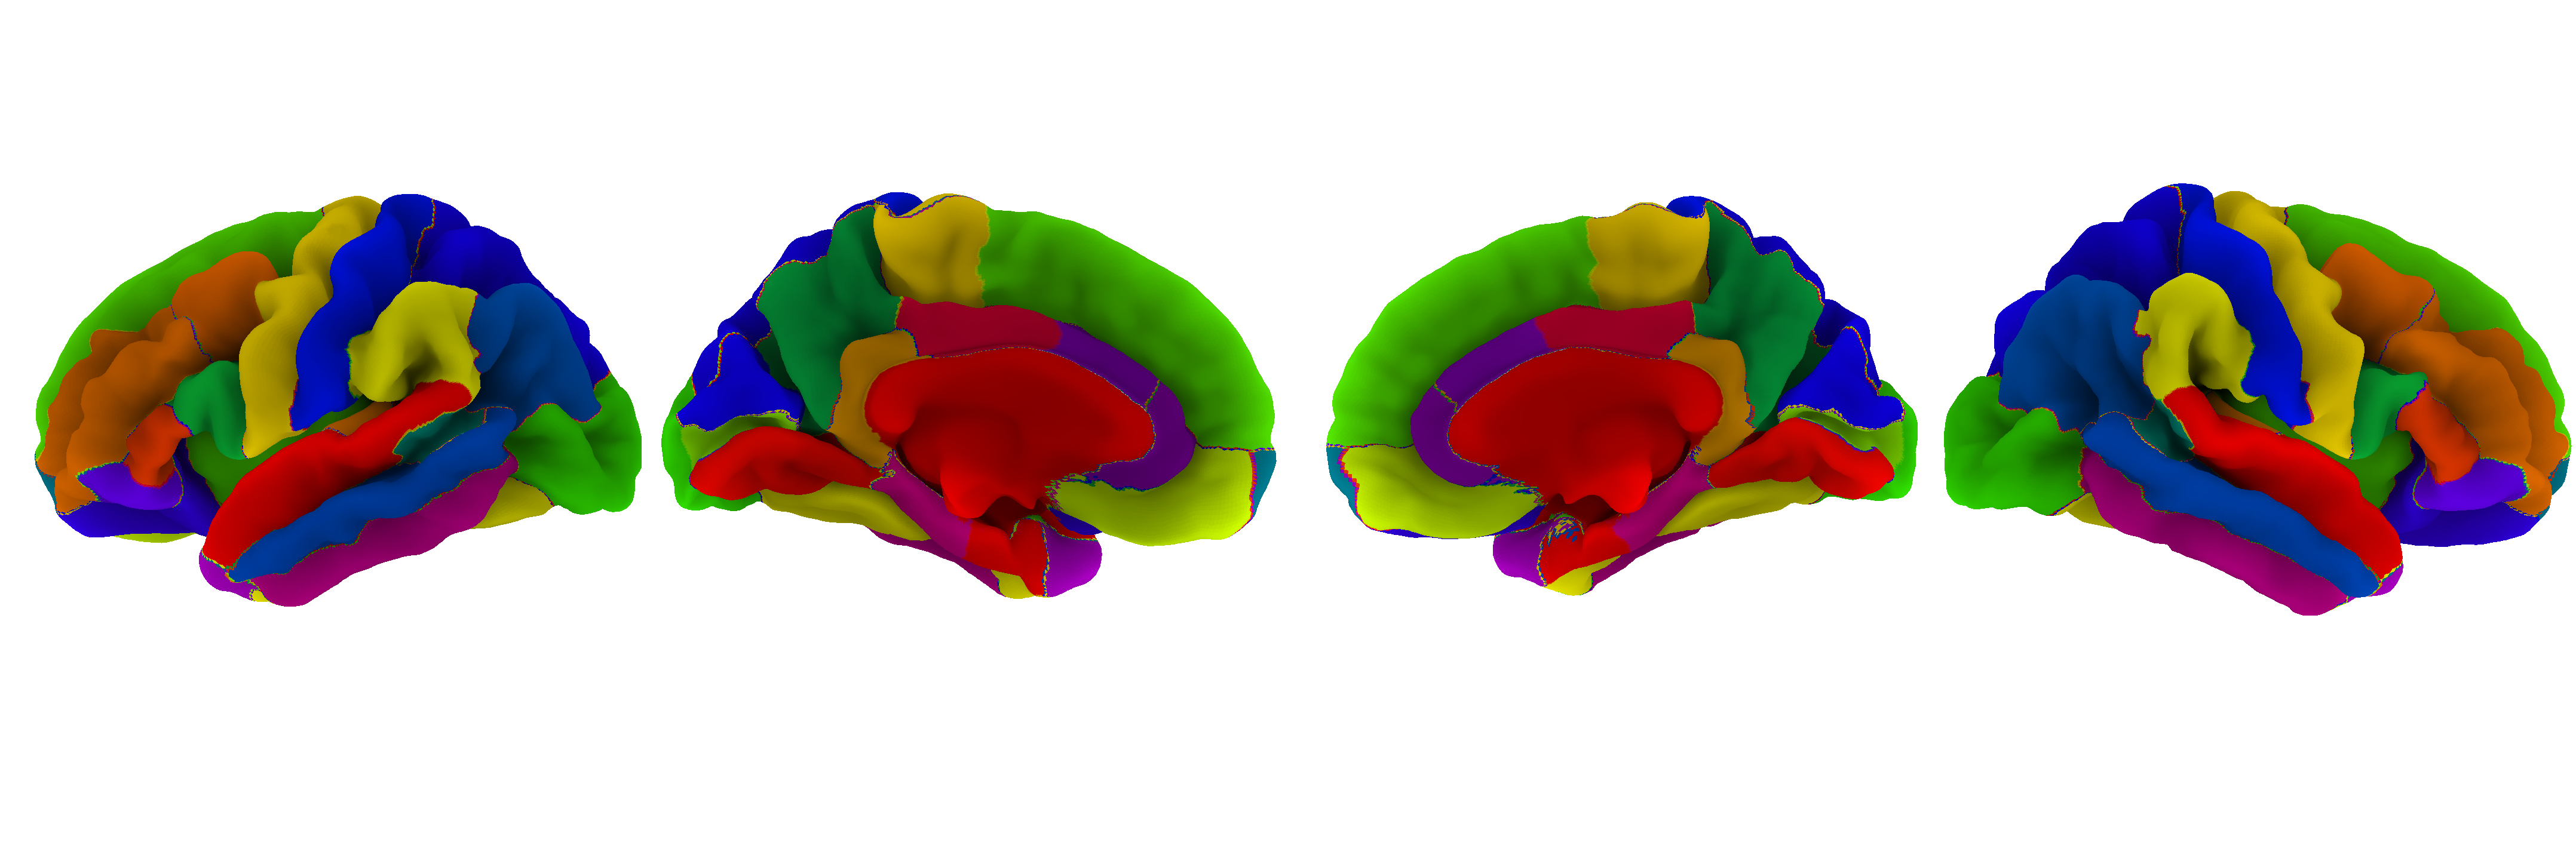

In [6]:
print 'Number of parcels =' ,len(DK_lh_names)*2
plot_surf(fsaverage, DK_lh_labels, DK_rh_labels, cmap = 'prism', alpha = 1)

# Desikan-Killany 308 cortical ROIS

Number of parcels = 308


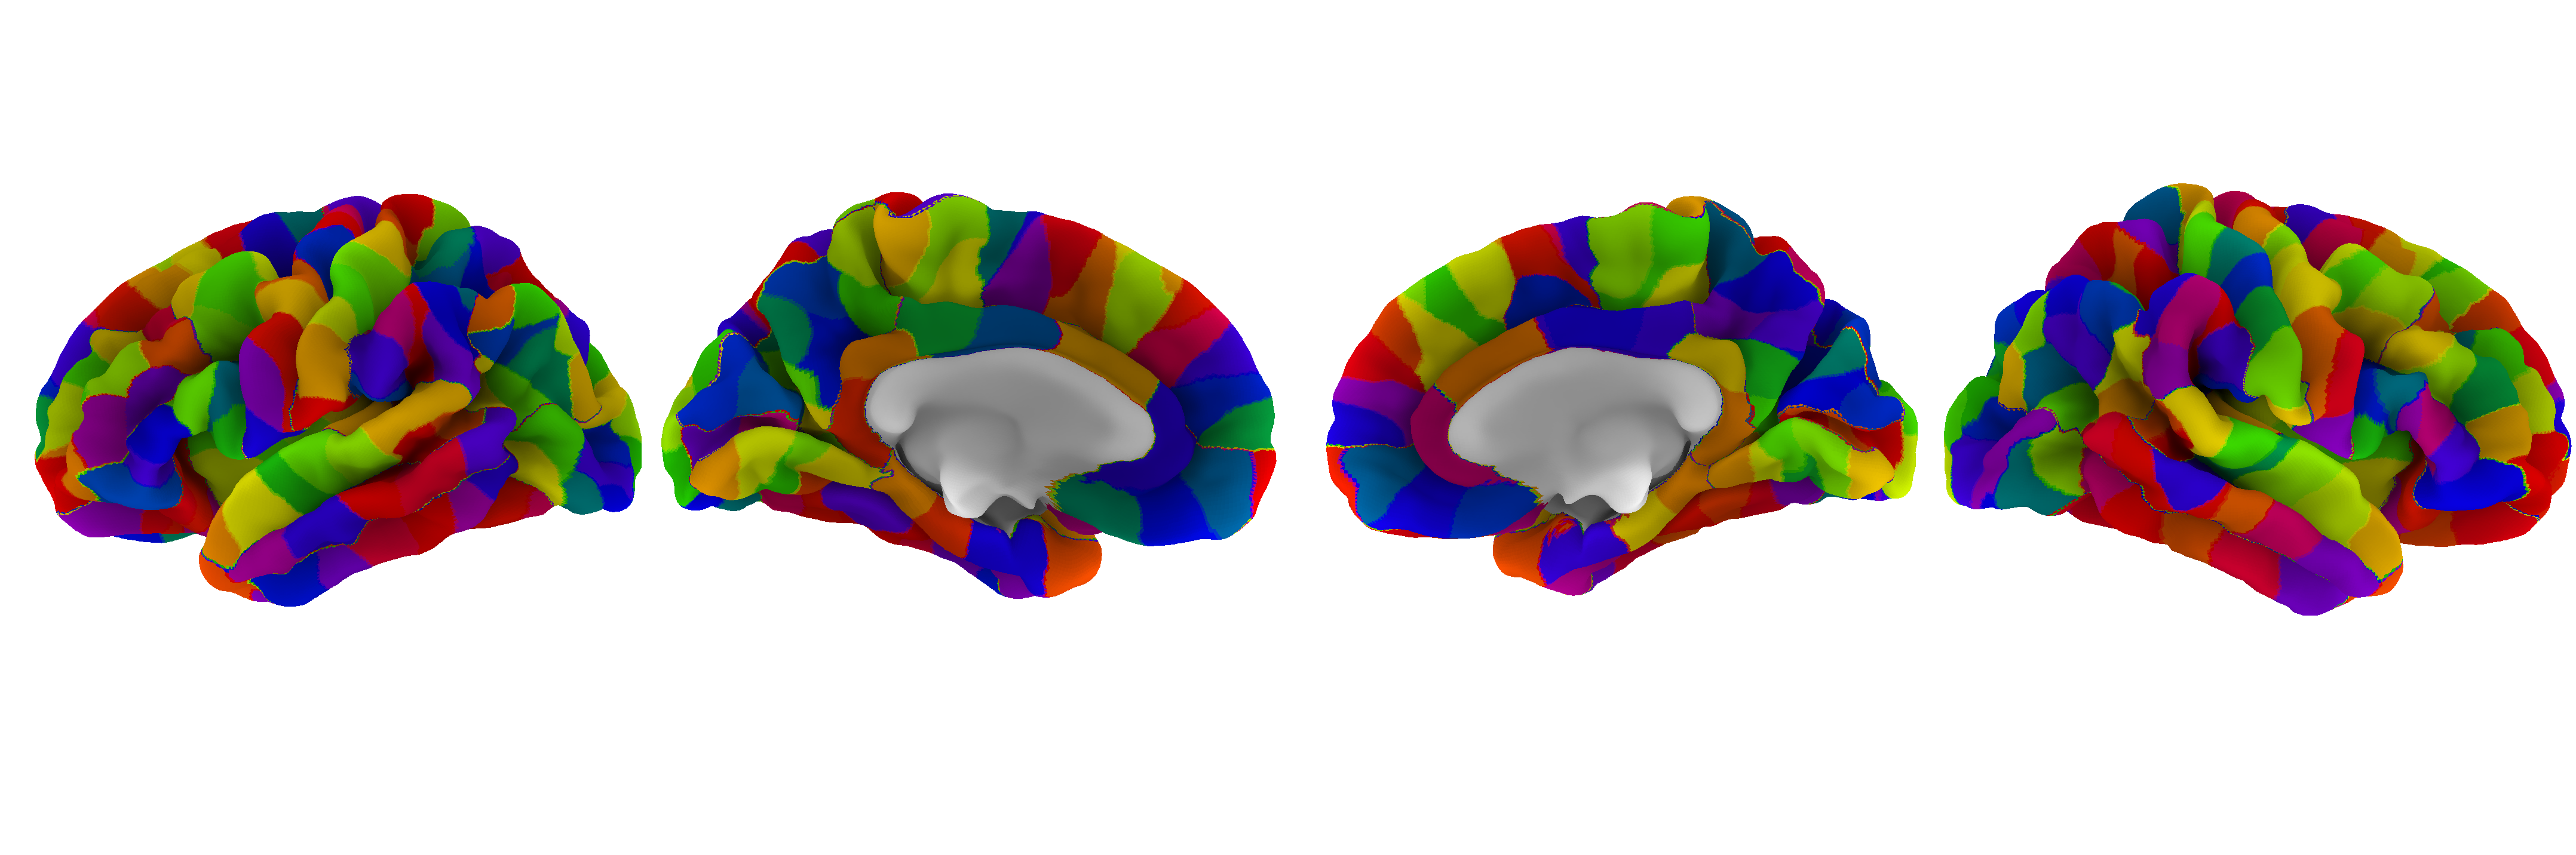

In [7]:
print 'Number of parcels =' ,len(DK500_lh_names)*2
plot_surf(fsaverage, DK500_lh_labels, DK500_rh_labels, cmap = 'prism', alpha = 1)

# Glasser 362 cortical ROIS

Number of parcels = 362


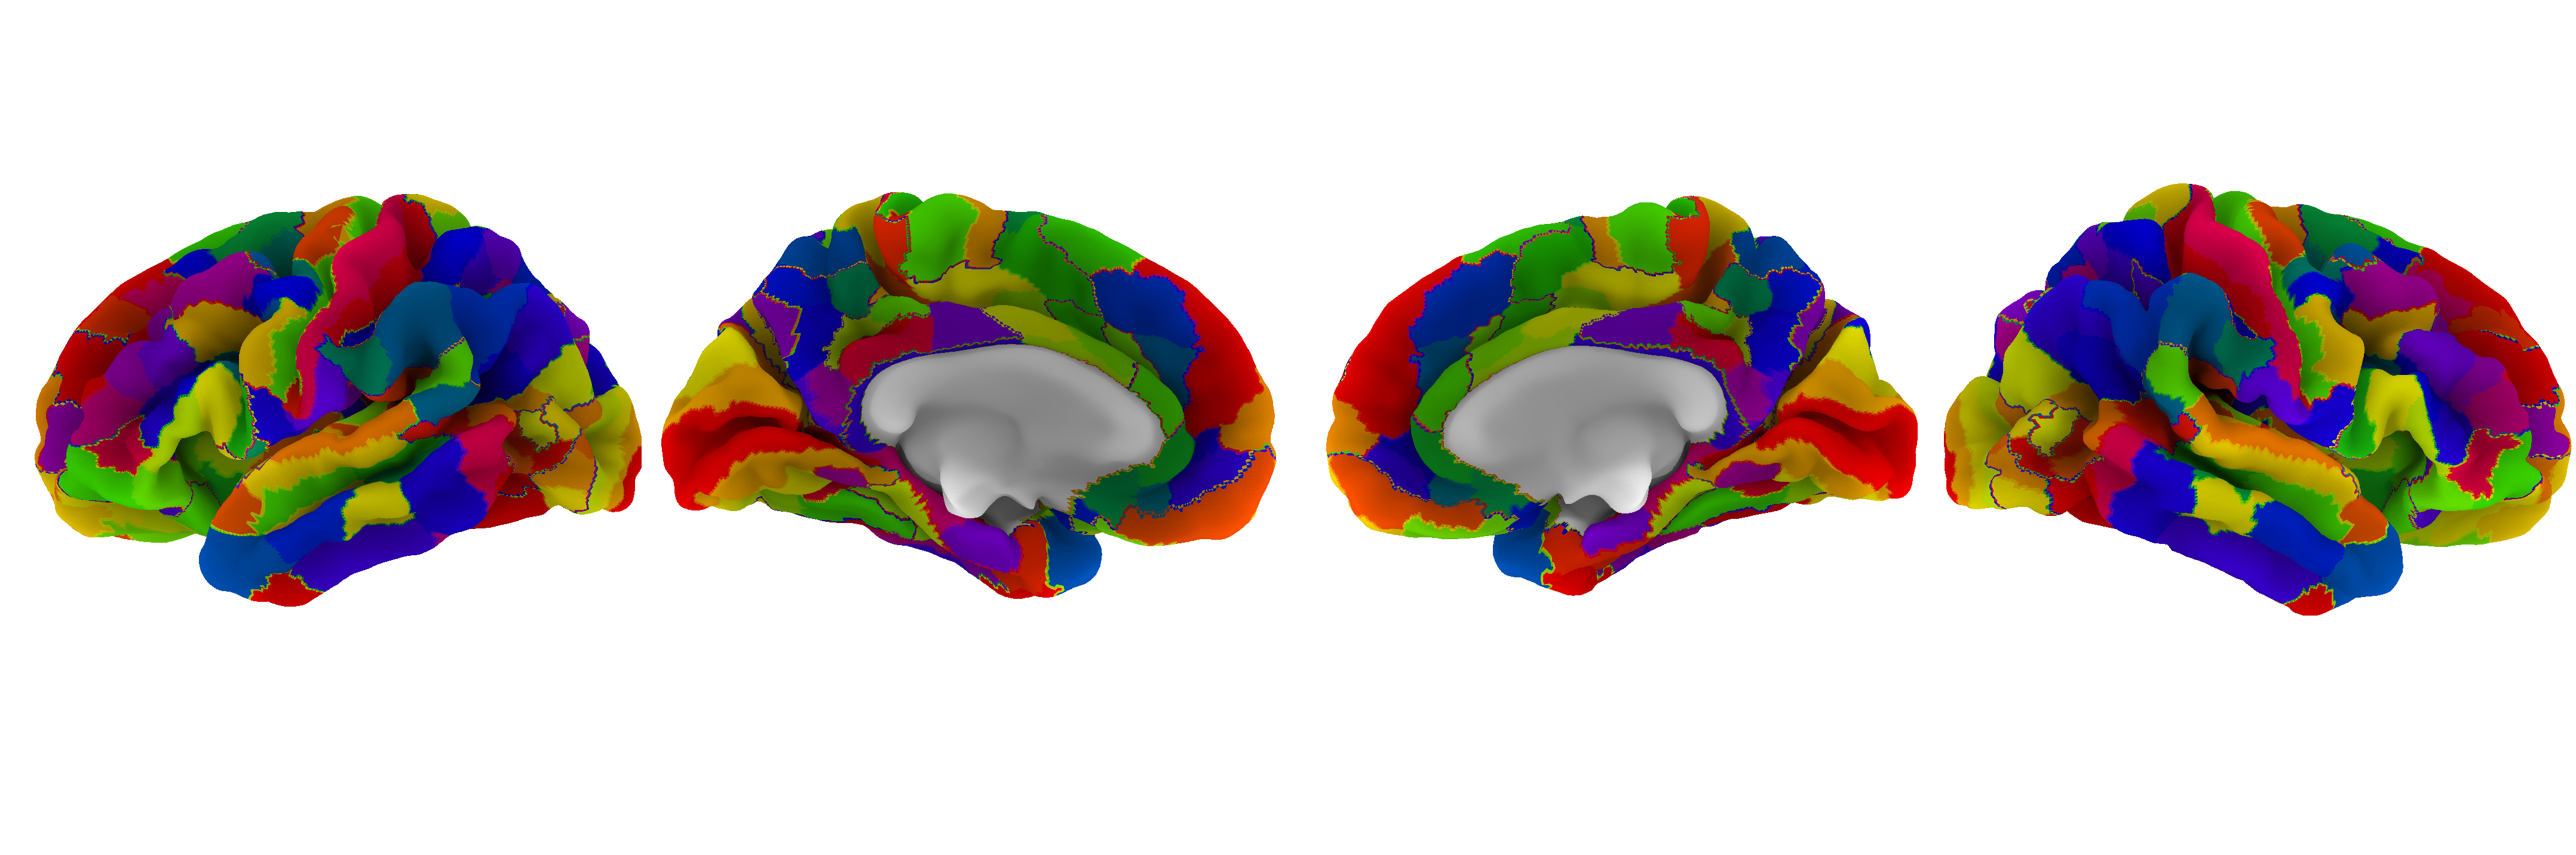

In [8]:
print 'Number of parcels =' ,len(HCP_lh_names)*2
plot_surf(fsaverage, HCP_lh_labels, HCP_rh_labels, cmap = 'prism', alpha = 1)

# Get parcellation centroids




In [9]:
def get_parcellation_centroids(img):
    import os 
    import subprocess
    os.system('rm -rf /tmp/*')
    
    # get unique labels (ie. parcels)
    labels_data = nb.load(img).get_data().astype(int)
    background_label = 0
    unique_labels = set(np.unique(labels_data)) - set([background_label])

    # find centroids of each parcel and dump into a dataframe
    df_centroids =pd.DataFrame(index = range(1, len(unique_labels)+1), columns = ['mni_coords'])
    
    for cur_label in unique_labels:
        os.system('fslmaths %s -thr %s -uthr %s /tmp/parc_%s.nii.gz' %(img,cur_label, cur_label, cur_label))
        centriod = subprocess.check_output('fslstats /tmp/parc_%s.nii.gz -c' %cur_label, shell=True)    
        #print cur_label, centriod
        df_centroids.loc[int(cur_label)]['mni_coords'] = centriod.strip()
    
    
    return df_centroids

In [10]:
DK500 = os.path.join(parcellation_dir,'fsaverage/centroids/500.aparc_renum_expanded.nii.gz')
DK500_centr = get_parcellation_centroids(DK500)

In [11]:
DK500_names      = pd.read_csv(os.path.join(parcellation_dir, 'fsaverage/centroids/500.names.txt'),header= None)
DK500_centr_orig = pd.read_csv('/scr/malta2/TOURETTOME/FS_SUBJECTS/fsaverageSubP/parcellation/500.centroids.txt', header=None)
DK500_lobes      = pd.read_csv('/scr/malta2/TOURETTOME/FS_SUBJECTS/fsaverageSubP/parcellation/500.lobes.txt', header=None)
DK500_voneconomo = pd.read_csv('/scr/malta2/TOURETTOME/FS_SUBJECTS/fsaverageSubP/parcellation/500.vonEconomoRegions.txt', header=None)

DK500_stats = pd.concat([DK500_names, DK500_lobes,DK500_voneconomo, DK500_centr_orig,],axis = 1)
DK500_stats.index += 1 
DK500_stats = pd.concat([DK500_stats, DK500_centr], axis=1)
DK500_stats.columns = ['Names', 'Lobes', 'VonEconomo','mni_coords_orig', 'mni_coords_calc']

DK500_stats
#len(DK500_lh_names) * 2

Names      Lobes  VonEconomo  \
1           Left-Cerebral-White-Matter          .           0   
2               Left-Lateral-Ventricle          .           0   
3                    Left-Inf-Lat-Vent          .           0   
4         Left-Cerebellum-White-Matter          .           0   
5               Left-Cerebellum-Cortex          .           0   
6                 Left-Thalamus-Proper          .           0   
7                         Left-Caudate          .           0   
8                         Left-Putamen          .           0   
9                        Left-Pallidum          .           0   
10                       3rd-Ventricle          .           0   
11                       4th-Ventricle          .           0   
12                          Brain-Stem          .           0   
13                    Left-Hippocampus          .           0   
14                       Left-Amygdala          .           0   
15                                 CSF          .           0   
16                 Left-Accumbens-area          .           0   
17                      Left-VentralDC          .           0   
18                         Left-vessel          .           0   
19                 Left-choroid-plexus          .           0   
20         Right-Cerebral-White-Matter          .           0   
21             Right-Lateral-Ventricle          .           0   
22                  Right-Inf-Lat-Vent          .           0   
23       Right-Cerebellum-White-Matter          .           0   
24             Right-Cerebellum-Cortex          .           0   
25               Right-Thalamus-Proper          .           0   
26                       Right-Caudate          .           0   
27                       Right-Putamen          .           0   
28                      Right-Pallidum          .           0   
29                   Right-Hippocampus          .           0   
30                      Right-Amygdala          .           0   
31                Right-Accumbens-area          .           0   
32                     Right-VentralDC          .           0   
33                        Right-vessel          .           0   
34                Right-choroid-plexus          .           0   
35                  WM-hypointensities          .           0   
36                        Optic-Chiasm          .           0   
37                        CC_Posterior          .           0   
38                    CC_Mid_Posterior          .           0   
39                          CC_Central          .           0   
40                     CC_Mid_Anterior          .           0   
41                         CC_Anterior          .           0   
42                   lh_bankssts_part1   temporal           3   
43                   lh_bankssts_part2   temporal           3   
44    lh_caudalanteriorcingulate_part1    frontal           1   
45        lh_caudalmiddlefrontal_part1    frontal           2   
46        lh_caudalmiddlefrontal_part2    frontal           2   
47        lh_caudalmiddlefrontal_part3    frontal           2   
48        lh_caudalmiddlefrontal_part4    frontal           2   
49                     lh_cuneus_part1  occipital           4   
50                     lh_cuneus_part2  occipital           4   
51                 lh_entorhinal_part1   temporal           2   
52                   lh_fusiform_part1   temporal           2   
53                   lh_fusiform_part2   temporal           2   
54                   lh_fusiform_part3   temporal           2   
55                   lh_fusiform_part4   temporal           2   
56                   lh_fusiform_part5   temporal           2   
57           lh_inferiorparietal_part1   parietal           3   
58           lh_inferiorparietal_part2   parietal           3   
59           lh_inferiorparietal_part3   parietal           3   
60           lh_inferiorparietal_part4   parietal           3   
61           lh_inferiorparietal_part5   parietal           3   
62 

# Load AHBA dataset 
* Matrix is wells(3702) x genes(20737) with an additonal 13 columns of metadata 

In [12]:
AHBA = pd.read_csv(os.path.join(ahba_dir, 'AHBA_20737.csv'),index_col=0)
META = AHBA.iloc[:,-28:]

/scr/malta1/Software/anaconda/envs/awesome/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (20763,20764,20765) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Drop wells outstide of the cerebral cortex
* Accomplished based on the ontology metadata 

In [13]:
ontology3        = set([AHBA.loc[well]['Ontology_3'] for well in AHBA.index])
CORTEX_wells     = [well for well in AHBA.index if AHBA.loc[well]['Ontology_3'] == 'cerebral cortex' ]
NON_CORTEX_wells = [well for well in AHBA.index if well not in CORTEX_wells]
print sorted(ontology3)
print ''
print 'Number of tissue samples (ie wells) within  the cerbral cortex =', len(CORTEX_wells)
print 'Number of tissue samples (ie wells)outside the cerbral cortex =', len(NON_CORTEX_wells)
print 'Sum should equal 3702 total wells. Check value here >>>> ', len(CORTEX_wells) + len(NON_CORTEX_wells)

['arcuate nucleus of medulla', 'central glial substance', 'cerebellum', 'cerebral cortex', 'cerebral nuclei', 'cochlear nuclei', 'cuneate nucleus', 'dorsal motor nucleus of the vagus', 'epithalamus', 'gracile nucleus', 'hypoglossal nucleus', 'hypothalamus', 'inferior olivary complex', 'lateral ventricle', 'medullary reticular formation', 'midbrain tectum', 'midbrain tegmentum', 'pons', 'pretectal region', 'raphe nuclei of medulla', 'spinal trigeminal nucleus', 'subthalamus', 'telencephalic commissures', 'telencephalic white matter tracts', 'thalamus', 'vestibular nuclei']

Number of tissue samples (ie wells) within  the cerbral cortex = 1950
Number of tissue samples (ie wells)outside the cerbral cortex = 1752
Sum should equal 3702 total wells. Check value here >>>>  3702


In [14]:
AHBA_CORTEX = AHBA.drop(NON_CORTEX_wells, axis =0)
AHBA_CORTEX

61E3.4      A1BG      A1CF    A26C1B      A2BP1     A2LD1  \
594        12.257452  4.307083  1.639045  6.047821  11.502535  2.992096   
2785       13.356659  5.087975  2.391748  4.590116  13.365749  3.558010   
2793       14.097546  5.008133  1.631623  6.620493  13.778565  2.772909   
2858       12.043521  5.013767  1.947309  6.272927  11.775498  2.128210   
2850       12.886543  5.411806  2.821428  4.249630  12.917862  2.913164   
787        11.901509  4.809929  2.154312  5.623660  11.624160  2.648934   
961        12.524298  4.753657  1.887817  5.652335  11.829915  2.804898   
428        12.933302  4.987472  1.780902  6.778148  12.181825  3.392491   
969        12.681659  4.848682  2.460850  6.098839  12.193359  2.882964   
973        12.849383  5.137261  1.694785  6.159993  11.733481  3.079358   
981        12.319410  5.474315  2.634324  5.620884  12.093912  3.009182   
989        12.811314  5.300154  2.650039  5.607378  12.103319  2.581836   
965        12.397764  5.304247  2.111797  5.758670  12.021336  2.722727   
1052       12.706076  4.894433  1.808542  6.004831  12.128118  3.081645   
1044       13.102670  5.025753  2.465108  6.321644  12.288283  3.277913   
1020       13.078316  5.319910  2.136164  6.515175  12.383187  2.854018   
1012       13.006964  4.735959  2.014521  6.283740  12.247585  2.871740   
1051       12.533532  5.304611  2.247309  5.893319  12.122172  2.809906   
964        12.489063  5.420257  2.860554  6.041011  12.108294  2.984595   
980        12.748784  6.986117  1.895666  5.785029  12.137798  2.751720   
996        12.384235  5.625779  2.312847  5.816388  12.087616  3.114167   
988        12.544000  5.202799  1.792133  6.027303  12.023829  3.182564   
1035       12.508571  4.802546  3.069014  6.018160  12.108063  2.791141   
1027       12.659891  5.082171  1.935856  6.153879  12.447168  3.125824   
1011       12.449309  5.250044  1.838254  6.032327  12.014078  3.048338   
1043       12.572914  5.596919  2.366338  5.855186  11.984829  3.327536   
979        12.674762  5.805246  3.251507  5.379103  12.353672  2.334765   
1003       12.458119  5.438087  1.993860  6.065477  12.238040  2.863989   
995        12.460146  5.302869  1.709980  5.785903  12.206860  2.592722   
971        12.617759  5.023671  2.221671  5.829661  11.777129  2.836779   
1034       12.605318  4.936575  2.426740  5.800158  11.842651  3.095922   
1042       12.706561  4.840424  2.109019  6.233344  12.238466  2.801100   
1010       12.563537  4.803335  1.991065  6.103306  12.035999  2.508448   
1018       12.448150  5.203028  1.976457  5.984728  12.215307  3.319374   
1026       12.689319  5.321518  3.026037  6.940599  11.862900  3.295013   
1002       12.815933  5.400648  1.721400  6.390886  12.117518  3.159458   
970        12.554006  5.127742  2.558417  6.153091  12.157614  2.680502   
978        12.350007  5.204291  1.986760  6.022115  11.917590  3.003315   
986        12.284266  5.541147  3.036657  6.310025  11.848579  2.929940   
962        12.561551  5.221999  1.838096  6.168374  12.003464  2.948129   
1017       12.316769  5.193205  1.824356  6.172330  11.943970  3.132651   
1025       12.654600  5.201416  2.055670  6.313379  12.194753  2.818671   
1033       12.552490  5.268501  2.271361  6.180706  12.192214  2.725055   
1041       13.282538  4.690102  1.871398  6.495720  12.648533  2.766781   
985        12.387208  4.828389  2.157367  6.213107  11.993282  2.818115   
993        12.269600  4.687842  2.056827  6.116660  12.072116  2.854822   
1009       12.551253  5.361416  2.285759  6.266264  12.074898  3.112043   
1049       12.456083  4.905976  1.816130  6.141203  11.820192  3.231278   
963        12.610588  4.648411  2.269438  6.315400  12.087631  2.742822   
1050       13.241989  4.756717  2.045327  6.566999  12.457270  2.992321   
362        12.223757  5.243809  2.259242  6.055925  11.960902  2.813283   
1001       12.387210  4.710746  1.777819  6.192069  11.870408  2.832525   
994        12.282872  5.449074  1.77969

# Calculate minimum euclidian distance for each well to parcellation units
* Romme, BiolPSych, 2017: "Cortical samples were volumetrically mapped to the Desikan–Killiany cortical parcellation atlas (DK; 57 regions per hemisphere) (Figure 1) (33), computing the minimal Euclidean distance of the reported Montreal Neurological Institute three-dimensional coordinates of each donor sample to the Montreal Neurological Institute coordinates of all voxels of FreeSurfer’s software’sfsaverage subject."